In [33]:
import pandas as pd  
import numpy as np
from glob import glob
from scipy.io import savemat, loadmat
from datetime import datetime, timedelta

import seaborn as sns
sns.reset_orig()
import matplotlib.pyplot as plt
import pdb

import psycopg2
import sqlite3
import os

from importlib import reload

import visualizeProfs as vp
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pchipOceanSlices import PchipOceanSlices

#reload(visualizeProfs)

/home/tyler/anaconda3/envs/argo/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/home/tyler/anaconda3/envs/argo/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/tyler/anaconda3/envs/argo/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/home/tyler/anaconda3/envs/argo/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/tyler/anaconda3/envs/argo/lib/python3.6/_collectio

In [26]:
pLevel = 50
files = glob('/home/tyler/Kuusela-Stein/Data/Data/**/obsProfResTrendTemp_at{}*.mat'.format(pLevel))
print(len(files))
dfkeys =  ['obsProfRes', 'profFloatIDAggrSel', 'profJulDayAggrSel', 'profLatAggrSel', 'profLongAggrSel']

1


In [7]:
def load_mat_file(file):
    mat = loadmat(file)
    mat['obsProfRes'] = mat['obsProfRes'][0]
    mat['profLatAggrSel'] = mat['profLatAggrSel'][0]
    mat['profLongAggrSel'] = mat['profLongAggrSel'][0]
    mat['profJulDayAggrSel'] = mat['profJulDayAggrSel'].flatten()
    mat['profFloatIDAggrSel'] = mat['profFloatIDAggrSel'].flatten()
    m = { key: mat[key] for key in dfkeys }
    dates = [pd.to_datetime(x[0]) for x in mat['strDate'].flatten()]
    df = pd.DataFrame.from_dict(m)
    df['date'] = dates
    df['profFloatIDAggrSel'] = df['profFloatIDAggrSel'].apply(lambda x: x.replace(' ', ''))
    return df

for file in files:
    print(file)
    matDf = load_mat_file(file)

/home/tyler/Kuusela-Stein/Data/Data/50.0/obsProfResTrendTemp_at50.0dbar_5_20.mat


In [96]:
matDf.head()

,obsProfRes,profFloatIDAggrSel,profJulDayAggrSel,profLatAggrSel,profLongAggrSel,date
0,-0.409769,5901454_44,733611.219942,-64.99900,272.23800,2008-07-22 05:16:43
1,-0.005490,5905680_0,737131.097014,-64.99803,178.81715,2018-03-12 02:19:42
2,-0.283841,5904162_1,735581.465127,-64.99800,224.13600,2013-12-13 11:09:47
3,-0.858705,7900210_0,735998.087465,-64.99675,164.75788,2015-02-03 02:05:57
4,-0.903310,7900210_2,735999.537789,-64.99654,164.75730,2015-02-04 12:54:25


In [97]:
# find highest residuals
residualThreshold = 10
suspectDf = matDf[abs(matDf['obsProfRes']) > residualThreshold]
suspectProfs = suspectDf['profFloatIDAggrSel'].tolist()
suspectProfs =  [x.replace(' ', '') for x in suspectDf]
print(suspectDf.shape)
suspectDf.head()

(115, 6)


,obsProfRes,profFloatIDAggrSel,profJulDayAggrSel,profLatAggrSel,profLongAggrSel,date
275813,-10.159800,5900860_204,734452.093171,-10.24200,85.970000,2010-11-10 02:14:10
394398,-10.505129,1901713_148,737205.388484,4.47313,323.093470,2018-05-25 09:19:25
413563,-10.010931,3900403_105,733532.799514,7.10700,244.117996,2008-05-04 19:11:18
414943,-10.437332,3900403_106,733543.580729,7.29100,244.394997,2008-05-15 13:56:15
416564,-10.356251,5900646_124,733519.898171,7.48400,236.327003,2008-04-21 21:33:22


In [98]:
def detect_outlier(res, threshold):
    outliers=[]
    mean = np.mean(res)
    std =np.std(res)
    for idx, y in enumerate(res):
        z_score= (y - mean)/std
        if np.abs(z_score) > threshold:
            outliers.append(idx)
    return outliers

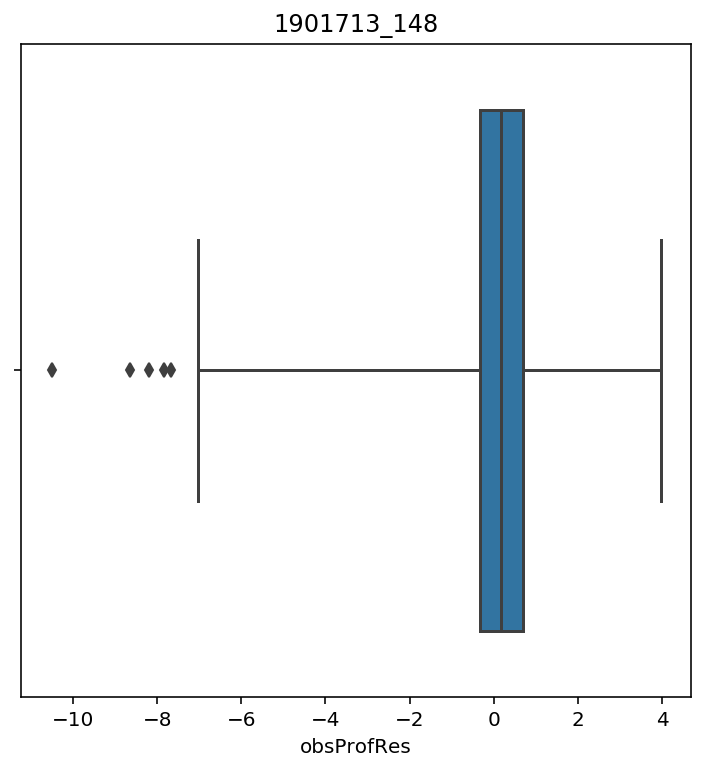

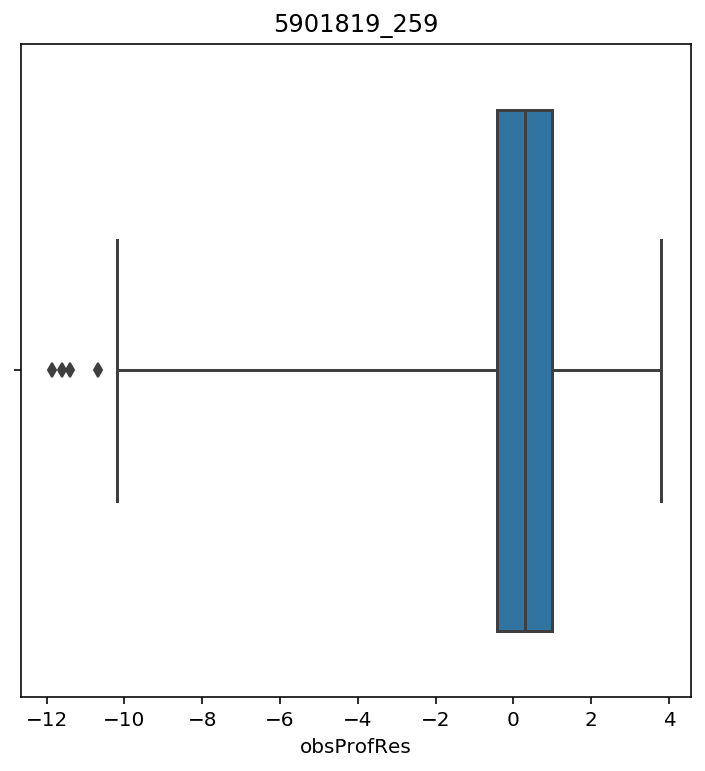

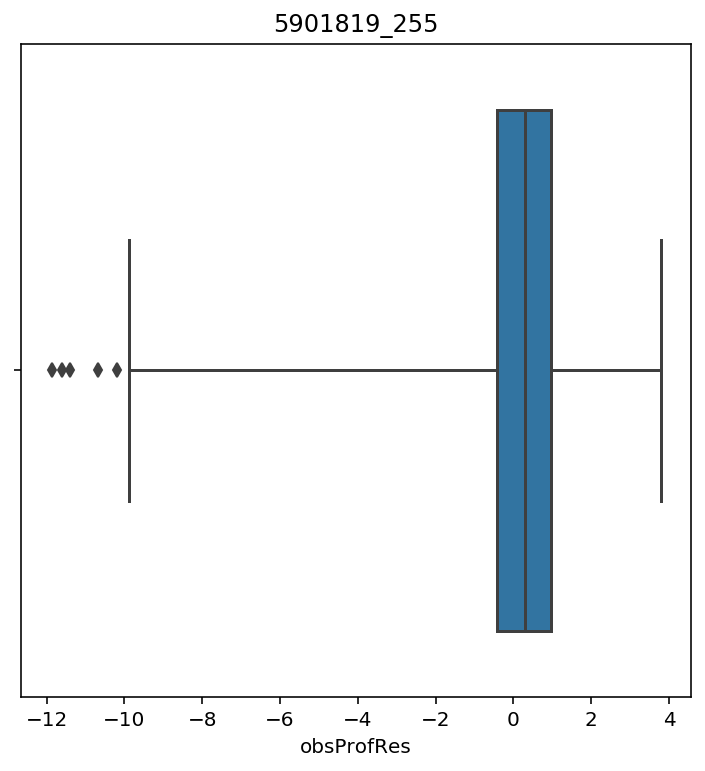

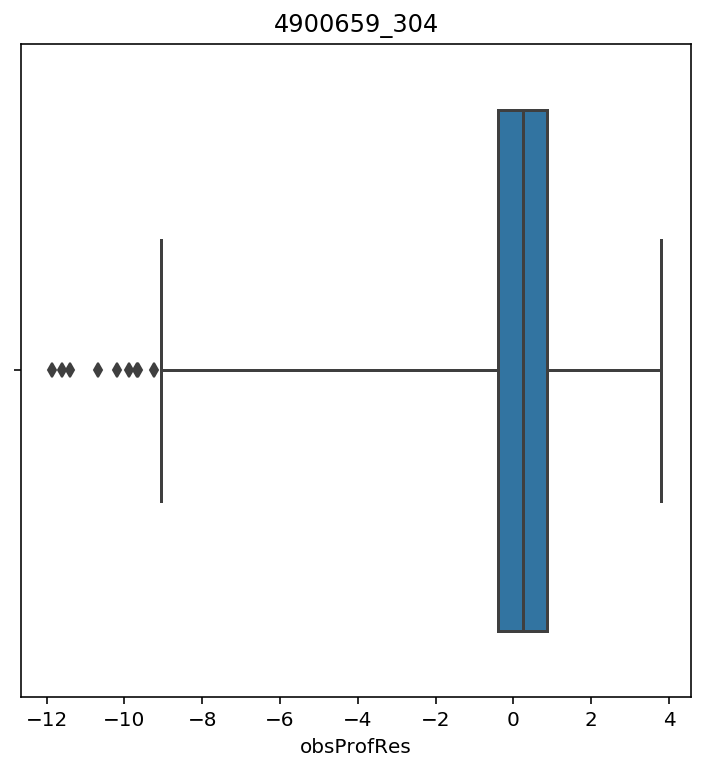

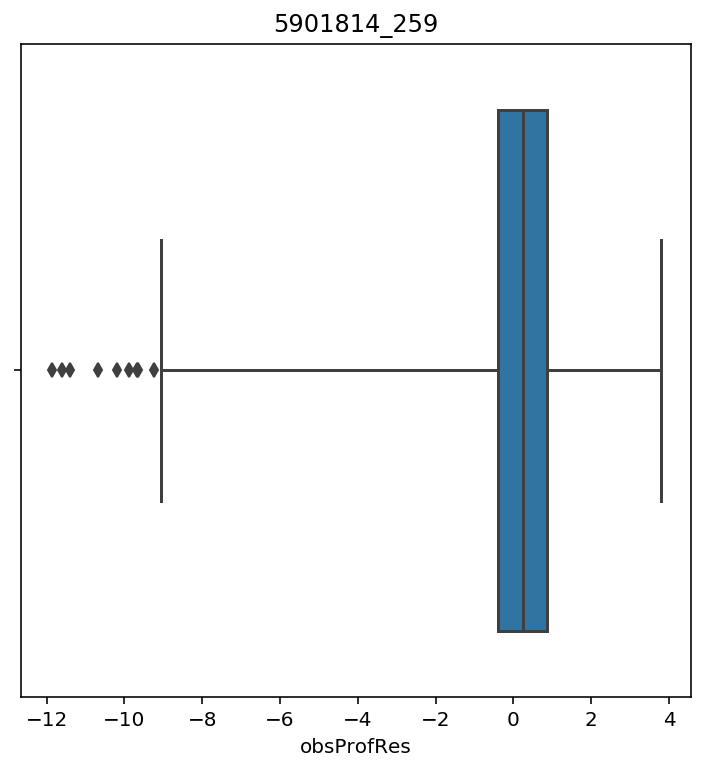

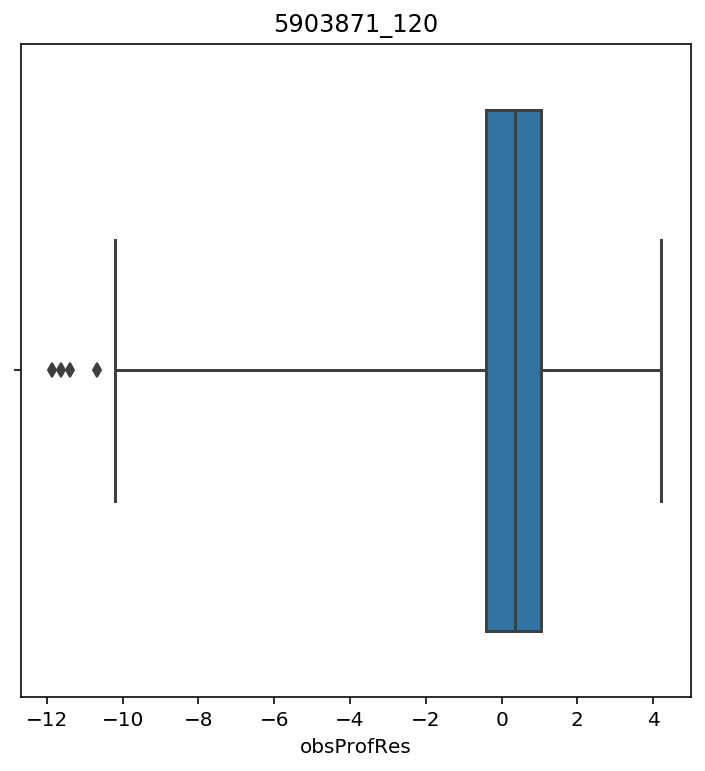

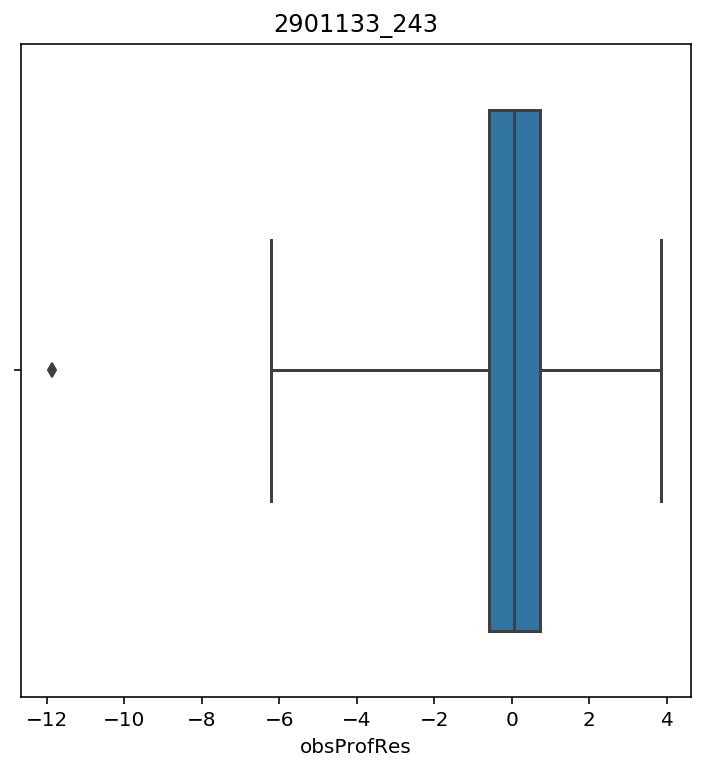

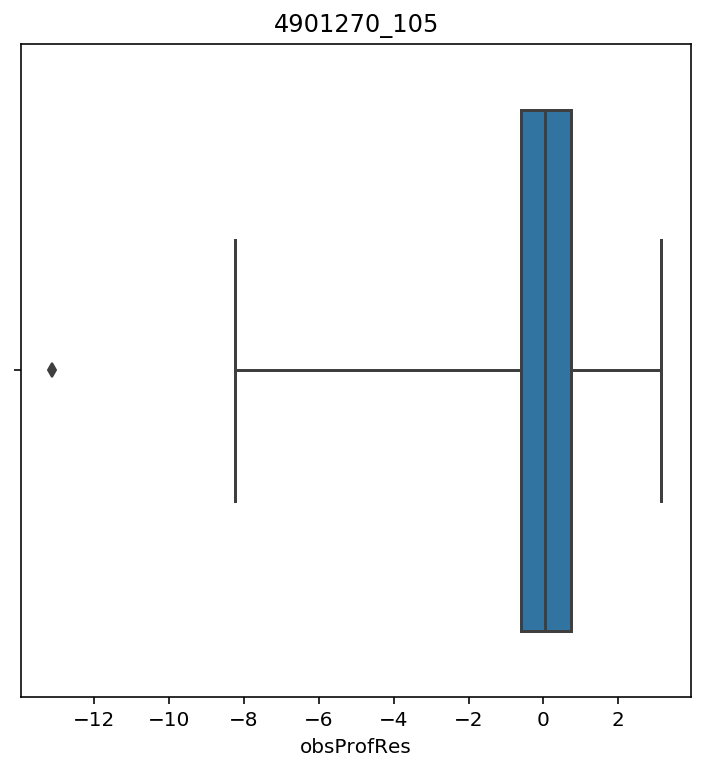

In [99]:
# get surrounding profiles from each row's lat-lon
window = 5 # degree window around outlier
outTH = 7 # n standard deviations away are considered outliers

outlierProfs = []
for row in suspectDf.itertuples():
    lat = row.profLatAggrSel
    long = row.profLongAggrSel
    
    query = (matDf['profLongAggrSel'] >= (long - window)) \
            & (matDf['profLongAggrSel'] <= (long + window)) \
            & (matDf['profLatAggrSel'] >= (lat - window)) \
            & (matDf['profLatAggrSel'] <= (lat + window))
    mdf = matDf[query]
    # construct a hist, with box plot
    
    outliers = []
    outliers = detect_outlier(mdf["obsProfRes"], outTH)
    outlierProfs += mdf['profFloatIDAggrSel'].iloc[outliers].tolist()
    if not len(outliers) == 0:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
        ax = sns.boxplot(x=mdf["obsProfRes"], whis=outTH)
        title = row.profFloatIDAggrSel
        ax.set_title(title)
#

In [100]:
profiles = vp.get_profiles_by_id(str(outlierProfs).replace(' ', ''))
if len(profiles) > 0:
    selectionDf = vp.parse_into_df(profiles)
selectionDf.replace(-999, np.nan, inplace=True)

In [101]:
iCol = 'temp'
xLab = 'pres'
yLab = iCol
xintp = pLevel
pLevelRange = [pLevel-10,pLevel+10]
pos = PchipOceanSlices(pLevelRange)
iDf = pos.make_interpolated_df(selectionDf, xintp, xLab, yLab)
iDf.date = pd.to_datetime(iDf.date)


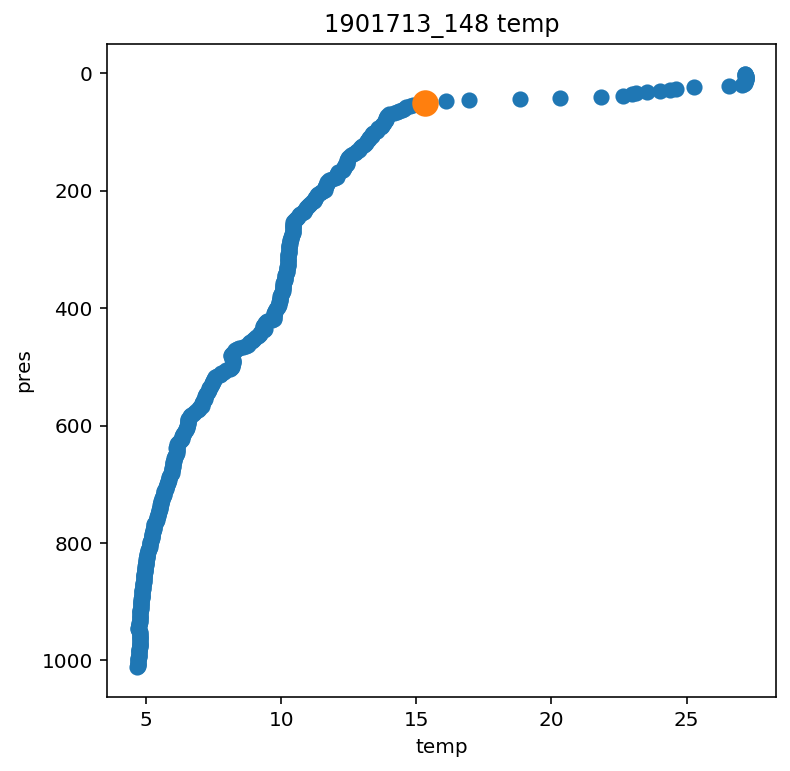

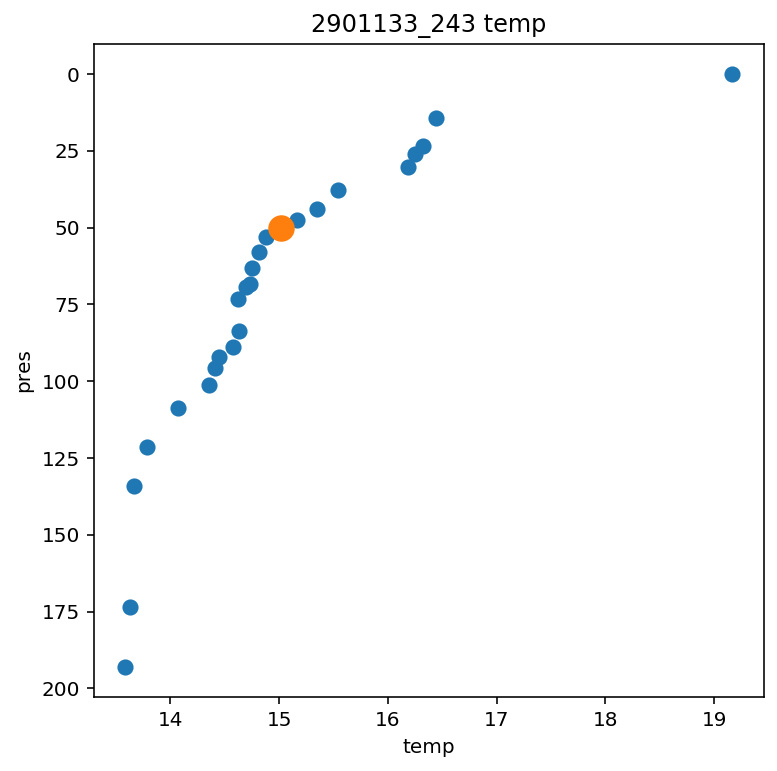

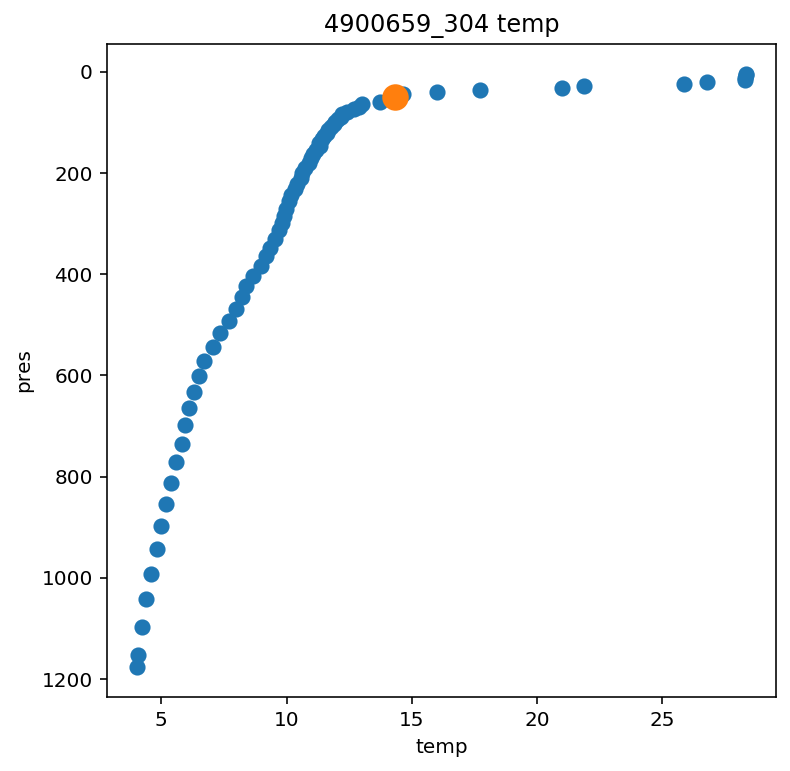

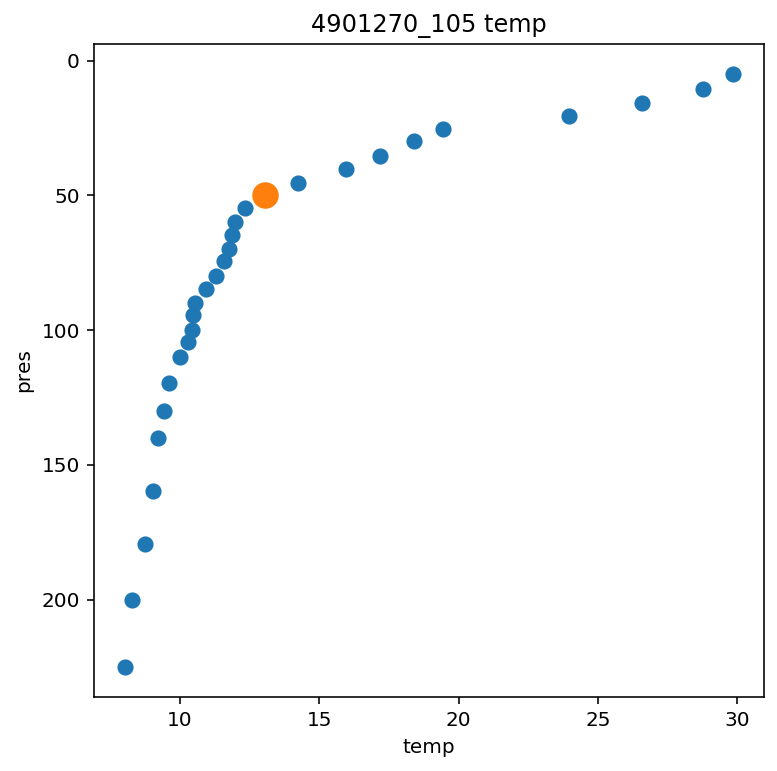

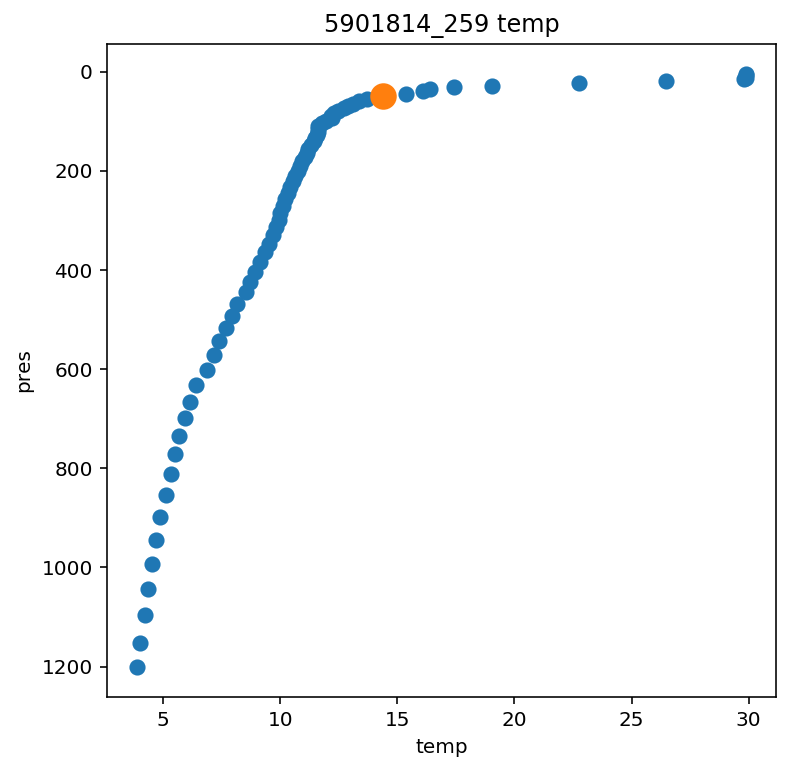

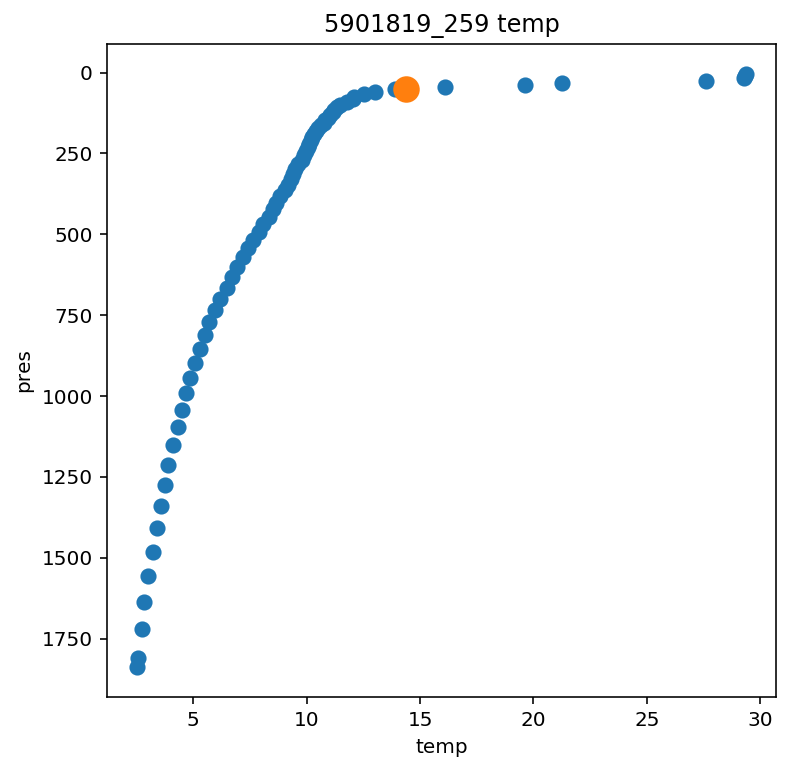

In [102]:
for profile_id, df in selectionDf.groupby('profile_id'):
    #fig.subplots_adjust(hspace=.35, wspace=.35)
    pdf = iDf[iDf['profile_id'] == profile_id]
    iX = pdf[iCol].iloc[0]
    iY = pdf[xLab].iloc[0]
    if pdf.empty or df.empty:
        continue
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
    if profile_id in {'6901002_100', '6901002_101', '6901740_127'} or np.isnan(iX):
        print('interpolated value is nan')
    ax = vp.plot_scatter(df, profile_id, 'temp', 'pres', axes)
    #plt.ylim((20,0))
    ax.scatter(iX, iY, s=150)

In [103]:
presRange = str(pLevelRange).replace(' ', '')
for profile_id, df in selectionDf.groupby('profile_id'):
    row = df.iloc[0]
    coord = {}
    coord['lat'] = row.lat
    coord['long'] = row.lon
    date = datetime.strptime(row.date, "%Y-%m-%dT%H:%M:%S.%fZ")
    startDate = datetime.strftime(date - timedelta(days=15), '%Y-%m-%d')
    endDate = datetime.strftime(date + timedelta(days=15), '%Y-%m-%d')
    shape = vp.construct_box(coord, 5, 5)
    print(row.profile_id)
    vp.build_selection_page_url(startDate, endDate, shape, presRange)

1901713_148
https://argovis.colorado.edu/selection/profiles/devpage?startDate=2018-05-10&endDate=2018-06-09&shape=[[[-34.40653,6.97313],[-39.40653,6.97313],[-39.40653,1.9731300000000003],[-34.40653,1.9731300000000003],[-34.40653,6.97313]]]&presRange=[40,60]
2901133_243
https://argovis.colorado.edu/selection/profiles/devpage?startDate=2011-10-21&endDate=2011-11-20&shape=[[[70.52,19.201],[65.52,19.201],[65.52,14.201],[70.52,14.201],[70.52,19.201]]]&presRange=[40,60]
4900659_304
https://argovis.colorado.edu/selection/profiles/devpage?startDate=2015-09-25&endDate=2015-10-25&shape=[[[-151.177,12.403],[-156.177,12.403],[-156.177,7.4030000000000005],[-151.177,7.4030000000000005],[-151.177,12.403]]]&presRange=[40,60]
4901270_105
https://argovis.colorado.edu/selection/profiles/devpage?startDate=2011-07-02&endDate=2011-08-01&shape=[[[-77.486,28.806],[-82.486,28.806],[-82.486,23.806],[-77.486,23.806],[-77.486,28.806]]]&presRange=[40,60]
5901814_259
https://argovis.colorado.edu/selection/profiles/

# Decide which profiles to eliminate

In [104]:
drop_profiles = {'2901133_243'}
drop_set_10 = drop_profiles.union({'2902100_104', '2902108_68', '5901884_302','6901002_126', '6901740_127'})
drop_set_50 = {'2901133_243'}

In [105]:
drop_set_10

{'2901133_243',
 '2902100_104',
 '2902108_68',
 '5901884_302',
 '6901002_126',
 '6901740_127'}

In [106]:
dropDf = matDf[matDf['profFloatIDAggrSel'].isin(drop_set_50)]

In [107]:
dropDf

,obsProfRes,profFloatIDAggrSel,profJulDayAggrSel,profLatAggrSel,profLongAggrSel,date
502498,-11.873875,2901133_243,734812.987072,16.701,68.02,2011-11-05 23:41:23


## Check with Gilsons special list

In [166]:
gLists = glob('/storage/kakapo/*temp*')
header = ['platform_number', 'cycle', 'lat', 'lon', 'c1', 'c2', 'c3', 'c4', 'c5']
def parse_kakapo(filename, header):
    '''parses reject and white list in kakapo'''
    with open(filename, "r") as f:
        data = f.readlines()
        lines = []
        for line in data: 
            line = ' '.join(line.split())
            line = line.split(' ')
            line[-1] = line[-1].replace('/n', '')
            lines.append(line)
    print(filename)
    df = pd.DataFrame(data=lines, columns=header)
    df['profile_id'] = df['platform_number'].apply(lambda x: str(x)) + '_'  + df['cycle'].apply(lambda x: str(x))
    return df

df = parse_kakapo(gLists[0], header)

/storage/kakapo/reject_cycle_fromvar_temp_01x01_finl


In [167]:
wl = glob('/storage/kakapo/*.xml')
dfwl = parse_kakapo(wl[0], header)


/storage/kakapo/ar_whitelist_2019.xml


In [165]:
dfwl.head()

,platform_number,cycle,lat,lon,c1,c2,c3,c4,c5,profile_id
0,1900243,23,None,None,None,None,None,None,None,1900243_23
1,1900243,25,None,None,None,None,None,None,None,1900243_25
2,1900243,30,None,None,None,None,None,None,None,1900243_30
3,1900243,31,None,None,None,None,None,None,None,1900243_31
4,1900243,32,None,None,None,None,None,None,None,1900243_32


In [159]:
df[df['profile_id'].isin(suspectDf['profFloatIDAggrSel'].tolist())]

,platform_number,cycle,lat,lon,c1,c2,c3,c4,c5,profile_id
1463,3900785,121,11.914,265.618,1,4.925,0.728,6.0xtimes,130.0,3900785_121
1726,1901713,148,4.473,323.093,0,11.731,1.745,6.0xtimes,50.0,1901713_148
1861,4900659,304,9.903,206.323,1,11.073,1.460,6.0xtimes,40.0,4900659_304
1862,5901814,259,9.944,206.631,1,11.190,1.507,6.0xtimes,40.0,5901814_259
1872,5903871,120,10.771,209.291,1,9.741,1.525,6.0xtimes,40.0,5903871_120
1951,3900403,106,7.291,244.395,1,11.211,1.614,6.0xtimes,30.0,3900403_106


# Create input instructions for matlab

In [108]:
[latGrid, longGrid] = np.meshgrid(np.linspace(-89.5,89.5,180),
                                  np.linspace(20.5,379.5,360));

In [109]:
gridDf = pd.DataFrame()
gridDf['lat'] = latGrid.flatten('F')
gridDf['long'] = longGrid.flatten('F')
gridDf.index = gridDf.index + 1

In [110]:
round_half = lambda x:  np.round(x-0.5)+0.5;

def make_redo_df(dropDf):
    redoDf = pd.DataFrame()

    for idx, row in dropDf.iterrows():
        lat = round_half(row.profLatAggrSel)
        long = round_half(row.profLongAggrSel)
        latBool = (gridDf['lat'] > lat - 5) & (gridDf['lat'] < lat + 5)
        longBool = (gridDf['long'] > long - 5) & (gridDf['long'] < long + 5)

        redoPoints = gridDf[latBool & longBool]
        redoDf = pd.concat([redoDf, redoPoints], axis=0, sort=False)
    redoDf = redoDf.drop_duplicates(keep='first')
    return redoDf

redoDf = make_redo_df(dropDf)

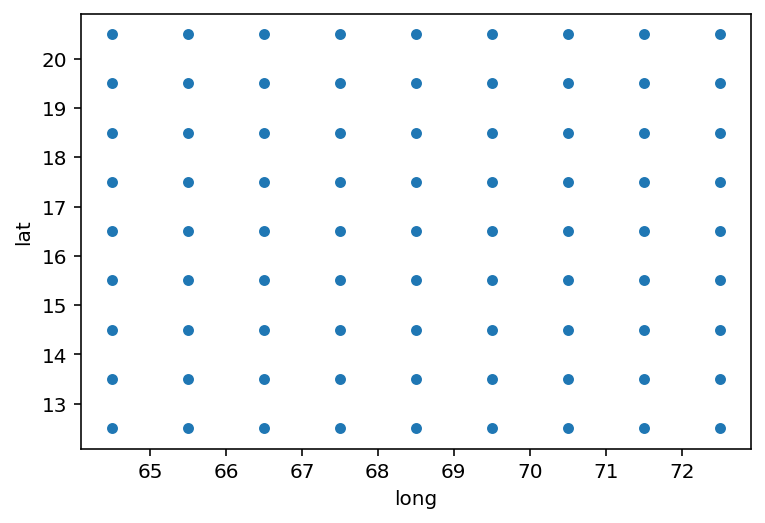

In [111]:
redoDf.plot(kind='scatter', x='long', y='lat')

In [112]:
def save_drop_mat(dropDf, redoDf, file):
    drop_id_list = dropDf.profFloatIDAggrSel.unique().tolist()
    lats = redoDf.lat.tolist()
    longs = redoDf.long.tolist()
    idxs = redoDf.index.tolist()
    a_dict = {'dropLats':lats , 'dropLongs': longs, 'dropIdxs': idxs, 'drop_ids': drop_id_list}
    dirname = os.path.dirname(file)
    redoFileName = 'redo'
    redoFilePath = os.path.join(dirname, redoFileName)
    print(redoFilePath)
    savemat(redoFilePath, a_dict)

In [113]:
save_drop_mat(dropDf, redoDf, file)

/home/tyler/Kuusela-Stein/Data/Data/50.0/redo


In [21]:
savemat(redoFilePath, a_dict)

NameError: name 'redoFilePath' is not defined

In [67]:
asdf  = gridDf[(gridDf['long'] >= long - 5) & (gridDf['long'] <= long + 5)]

In [76]:
redoPoints.long.min()


78.5

In [51]:
gridDf = pd.DataFrame()
gridDf['lat'] = latGrid.flatten('C')
gridDf['long'] = longGrid.flatten('F')

In [52]:
gridDf.head()

,lat,long
0,-89.5,20.5
1,-88.5,21.5
2,-87.5,22.5
3,-86.5,23.5
4,-85.5,24.5
